<a href="https://colab.research.google.com/github/brunoodon/mvp_sprintII/blob/main/MVP_Sprint_II(A).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVP - Machine Learning - Sprint II**

# Definição do problema
É um problema de classificação, com aprendizado supervisionado. Trata-se de um dataset de transações de BitCoin para resgate de arquivos criptografados por Ransomwares.
O objetivo deste modelo é tentar prever o tipo de Ransomware baseado no aprendizado dos dados das transações durante os anos.
## Descrição do dataset:
O Bitcoin Heist Data é um histórico de transações de criptomoedas coletadas com 24 horas de intervalo. Os destinos dessas transações são grupos de criminosos que criptografaram arquivos de vitmas ao redor do mundo via infecção por Ransomwares diversos. Nesse caso, o criminoso emitia uma nota de resgate com o endereço para pagamento do resgate dos arquivos.

**Campos do dataset:**

address: endereço de bitcoin - String;

year: ano da transação - Integer;

day: dia do ano (dias corridos - de 1 a 365) - Integer;

length: Integer;

weight: Float;

count: Integer;

looped: Integer;

neighbors: Integer;

income: quantidade de Satoshis depositados (1 bitcoin = 100 milhões de Satoshis) - Integer;

label(target): família de Ransomware que infectou a vítima. Quando o label é 'White', significa que não foi possível detectar se a transação foi para pagamento de resgate ou não - String.









In [1]:

import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
##importando os módulos da biblioteca sklearn para realizar a modelagem
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

#Preparação dos dados

Neste estágio, vamos carregar o dataset, ordenar por ano (mais recente) e tratar os missgins.

In [2]:
#carregando o dataset
url = 'https://raw.githubusercontent.com/brunoodon/mvp_sprintII/main/BitcoinHeistData_MVP.csv'
dataset = pd.read_csv(url).sort_values(by='year', ascending=False)
#Limpando os missings do dataset e fazendo a verificação de que realmente não existem
dataset.dropna(inplace=True)
display(dataset)
missings = dataset.isnull().sum()
display(missings)

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
763,12iETtj5gKJ5vz26rUGQtnifDjJy3FHhJX,2017,34,14,0.062500,1,0,2,80000000.0,princetonCerber
797,12im6r2cFxu7aonCQrz8gedA8XPKkWUWk2,2017,35,2,0.100000,1,0,2,75000000.0,princetonCerber
800,12ir91LHrWN8Pdt3V9kYgosjPbiLDTu8fN,2017,23,10,1.000000,3,0,1,400000000.0,princetonLocky
3677,13V7WsqJDnQ7v56jFkKNTMihJQMdvL3WYg,2017,37,4,0.015625,1,0,2,75000000.0,princetonCerber
...,...,...,...,...,...,...,...,...,...,...
1717,12wQZTDmA8onM3sEt4jwcvzDxnNXxD8Vza,2011,363,0,0.050195,2,0,4,110100526.0,montrealCryptoLocker
1710,12wQZTDmA8onM3sEt4jwcvzDxnNXxD8Vza,2011,359,0,0.019608,1,0,2,60065981.0,montrealCryptoLocker
4467,14EZSJRGdxaioeDETxskw4FN69NeDjqQNT,2011,291,4,0.125000,1,0,2,52036465.0,montrealCryptoLocker
1695,12wQZTDmA8onM3sEt4jwcvzDxnNXxD8Vza,2011,357,12,0.446947,54,0,3,476565460.0,montrealCryptoLocker


address      0
year         0
day          0
length       0
weight       0
count        0
looped       0
neighbors    0
income       0
label        0
dtype: int64

Para facilitar a análise, vamos fazer uma representação gráfica da distribuição de transações de resgate de arquivos por ano e as respectivas famílias de Ransomwares que causaram o problema.

Importante atentar para o fato de que algumas transações de resgate ocorreram exclusivamente em um ano específico, como o caso da família montrealWannaCry, em 2017.

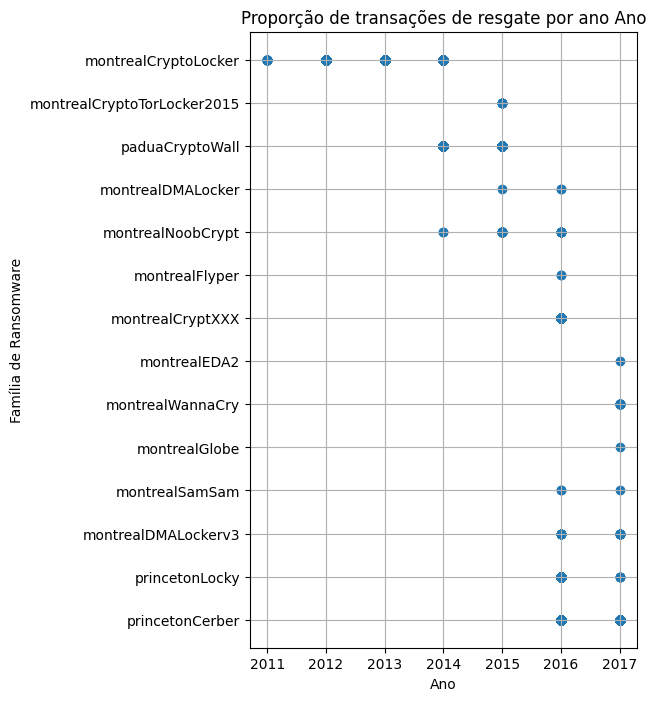

In [3]:
#definindo o dataframe e os eixos para a exibição do gráfico tipo scatter plotter
df = dataset[["year", "label"]]
plt.figure(figsize=(5,8))
y = df['label']
x = df['year']
plt.scatter(x, y)
plt.title("Proporção de transações de resgate por ano Ano")
plt.xlabel("Ano")
plt.ylabel("Família de Ransomware")
plt.grid(True)
plt.show()


# Separação e Transformação dos dados

Aqui, vamos fazer a normalização dos dados e a sepação em conjuntos de treino e teste.

In [4]:
array = dataset.values
X = array[:,1:9]
max = np.max(X)
min = np.min(X)
X_norm = (X - min) / (max - min)
y = array[:,9]
#X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.20, random_state=7)
X_norm_train, X_norm_test, y_train, y_test, = train_test_split(X_norm, y, test_size=0.20, random_state=7)
display(X_norm)

array([[4.532584269662922e-09, 2.4719101123595506e-11,
        4.044943820224719e-11, ..., 0.0, 4.49438202247191e-12,
        0.0002248314606741573],
       [4.532584269662922e-09, 7.640449438202247e-11,
        3.146067415730337e-11, ..., 0.0, 4.49438202247191e-12,
        0.00017977528089887642],
       [4.532584269662922e-09, 7.865168539325843e-11,
        4.49438202247191e-12, ..., 0.0, 4.49438202247191e-12,
        0.00016853932584269662],
       ...,
       [4.519101123595505e-09, 6.539325842696629e-10,
        8.98876404494382e-12, ..., 0.0, 4.49438202247191e-12,
        0.00011693587640449438],
       [4.519101123595505e-09, 8.022471910112359e-10,
        2.696629213483146e-11, ..., 0.0, 6.741573033707865e-12,
        0.0010709336179775281],
       [4.519101123595505e-09, 7.617977528089887e-10,
        4.49438202247191e-12, ..., 0.0, 4.49438202247191e-12,
        0.0001251569797752809]], dtype=object)

KNN: 0.614655 (0.024502)
CART: 0.579013 (0.024573)
NB: 0.363403 (0.014396)
SVM: 0.290626 (0.027854)


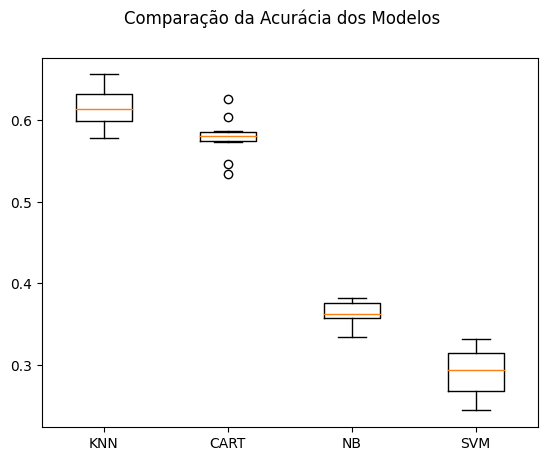

In [5]:
num_particoes = 10
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7)
np.random.seed(7)
models = []
results = []
names = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))


for name, model in models:
  cv_results = cross_val_score(model, X_norm_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # média e desvio padrão dos 10 resultados da validação cruzada
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação da Acurácia dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()



In [6]:
model = KNeighborsClassifier()
model.fit(X_norm_train, y_train)
predictions = model.predict(X_norm_test)
print(accuracy_score(y_test, predictions))

0.6454183266932271
